Este notebook lo usamos para sacar los datos de los recorridos que (por desgracia) se tienen que sacar a mano.

Cosas que pongo aquí porque si no se me olvidan:

* Los carriles se enumeran desde 0 (el derecho) hasta n (el más izquiero de todos). Eso quiere decir que los cambios son -1 a la derecha y +1 a la izquierda.
* Si el siguiente semáforo está muy lejos, nos da exactamente igual el estado en el que esté. Este hecho lo podemos usar para generar más datos.
* La precisión del GPS es un poco chusta, así que los resultados mejorarían dramáticamente en el caso de conseguir una mayor precisión en la toma de datos.

In [40]:
%matplotlib notebook

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

from pynsia.pointcloud import PointCloud
from utils import load_subject_df, DATASETS_INFO

figsize = (8, 4)

In [41]:
# BASE_PATH = '/home/blazaid/Projects/data-phd/sync'
BASE_PATH = '/media/blazaid/Saca/Phd/data/sync'
SUBJECT = 'miguel'  # edgar, jj, miguel
DATASET = 'validation'  # training, validation

In [42]:
# Load the subject's data
df = load_subject_df(BASE_PATH, SUBJECT, DATASET, 'dataset')
# Select user info
dataset_info = DATASETS_INFO[SUBJECT][DATASET]
# Subject's path
SUBJECT_PATH = os.path.join(BASE_PATH, SUBJECT, DATASET)
# Calibration data
calibration_data = dataset_info['calibration_data']

In [45]:
def plt_image(ax, index, path):
    image = mpimg.imread(path)
    ax.clear()
    ax.imshow(image)
    ax.text(0, 0, 'Frame ' + str(index), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

def plt_lidar(ax, path, columns):
    ps = PointCloud.load(path).transform(**calibration_data).points
    
    # Extract the points in the specified bounding box
    mask = (ps[:,2] > -1.5) & (ps[:,2] < 0.5) & (ps[:,0] < 35) & (ps[:,0] > 0.35) & (ps[:,1] < 1) & (ps[:,1] > -1)
    masked_points = ps[mask,:]

    # Look for clusters and extract the distance to them
    n_clusters = 0
    n_points = len(masked_points)
    dist = np.inf
    nearest_c = None
    if n_points > 0:
        db = DBSCAN(eps=1, min_samples=2).fit(masked_points)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        for cluster in range(n_clusters):
            centroid_ps = masked_points[labels == cluster]
            centroid_dist = np.sqrt(np.mean(centroid_ps[:, 0])**2 + np.mean(centroid_ps[:, 1])**2)
            if centroid_dist < dist:
                dist = centroid_dist
                nearest_c = centroid_ps

    ax.clear()
    ax.set_xlim((-35, 35))
    ax.set_ylim((-35, 35))
    ax.set_aspect('equal', adjustable='box')
    if nearest_c is not None:
        ax.scatter(nearest_c[:,0], nearest_c[:,1], s=.1, color='r');
    ax.scatter(ps[:,0], ps[:,1], s=.01, color='b', alpha=0.1);
    ax.text(-30, 30, 'Clusters: ' + str(n_clusters), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    ax.text(-30, 20, 'Dist: ' + str(dist), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

<IPython.core.display.Javascript object>


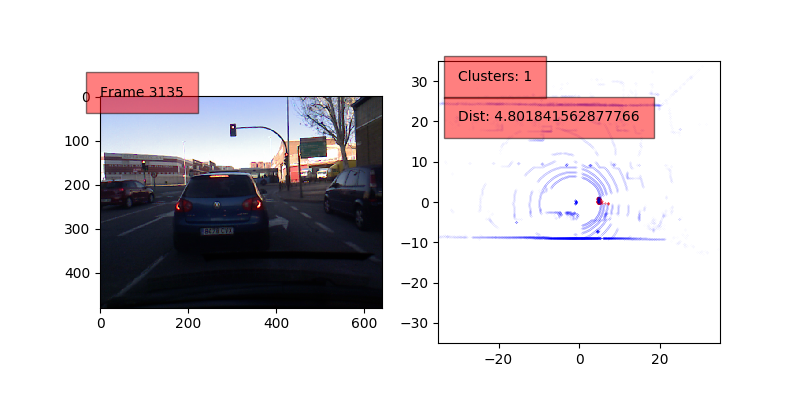

KeyboardInterrupt: 

In [46]:
import time

from_index = 3115

fig, axs = plt.subplots(1, 2, figsize=figsize)
columns = []
for index, row in df.iterrows():
    if from_index is not None and from_index <= index:
        if not (pd.isnull(row['snapshots_path']) or pd.isnull(row['pointclouds_path'])):
            plt_image(axs[0], index, os.path.join(SUBJECT_PATH, row['snapshots_path']))
            plt_lidar(axs[1], os.path.join(SUBJECT_PATH, row['pointclouds_path']), columns)
        fig.canvas.draw()